First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [14]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [15]:
executed_by ='stud-id_12129099'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [16]:
# group id for this project
group_id = '84'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12205610'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12129099'  # Replace the digits after "id_" with student B's student ID

In [17]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [18]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [19]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [20]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [21]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Jonathan" .',
f':{student_a} foaf:familyName "Maier" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "12205610" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "01234567"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Morgan" .',
f':{student_b} foaf:familyName "Stern" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [22]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## Business Understanding 

In [31]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [32]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
Scenario:       We founded the Company "Fritz & Maier AG" after our Bachelors, which is a software company that has scaled rapidly to hundreds of employees that are located all over the world. 
                Due to this rapid expansion, the current compensation structure is ad-hoc, resulting in internal pay inequities and potential misalignment with the current market. 
                As the company matures and growes even further, HR requires a data-driven approach to standardize these salaries. 
                The goal is to use the Stack Overflow data to analyze the relationship between skills, experience, and education against compensation to benchmark current employee salaries make adaptions for the following business year.

Data Source:    The analysis utilizes the Stack Overflow Annual Developer Survey 2025. 
                This dataset contains comprehensive information regarding developer demographics, experience, technology usage, and compensation from a global audience.

"""

business_objectives_comment = """
The primary objective is to establish a data-driven salary benchmarking model to find a fair market value for software engineering roles based on objective factors such as experience, location and their tech stack.

Secondary Objectives:
1. Identify current employees who may be significantly under- or overpaid compared to the market.
2. Standardize salary offers for new hires to reduce negotiation time.
3. Ensure the company's budget is optimized by avoiding arbitrary overpayment while maintaining competitiveness.
"""

business_success_criteria_comment = """
1. Salary Model Adoption: The HR department successfully adopts the model to review at least 80% of current employee contracts.
2. Turnover Reduction: A measurable reduction in staff turnover attributed to compensation issues.
3. Offer Acceptance: An increase in the acceptance rate of initial job offers for new hires, indicating that the data-backed offers are competitive.
5. Budget Optimization: Achieving a total salary budget that aligns within +/- 10% of the predicted market benchmark, ensuring the company is neither overspending nor significantly underpaying.
6. Faster Time-to-Hire: A reduction in the average time required to close a candidate, specifically by shortening the salary negotiation phase through transparent, data-backed offers.
"""

data_mining_goals_comment = """
...
"""

data_mining_success_criteria_comment = """
...
"""

ai_risk_aspects_comment = """
...
"""

bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

In [33]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
    f':data_understanding_phase rdf:type prov:Activity .',
    f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


### Summary of Issues Found
Before proceeding to the Data Preparation phase, we have identified **six critical data quality issues** that must be addressed to build a valid regression model for Salary prediction. This report outlines the issues and prescribes the necessary processing steps.

1.  **Missing Values in Target Variable (`ConvertedCompYearly`):**
    * **Issue:** A significant portion of the dataset has no recorded salary (`NaN`). This often happens when respondents choose not to share financial information.
    * **Impact:** Supervised learning models (like Regression) cannot learn from examples where the "answer" is missing.
    * **Processing Action:** **Drop all rows** where `ConvertedCompYearly` is missing. Do not attempt to fill/impute the target variable.

2.  **Extreme Outliers in Target Variable (`ConvertedCompYearly`):**
    * **Issue:** The salary distribution is heavily distorted by values reaching $50M+, which are verifiable entry errors (e.g., users entering values in local currency but selecting "USD").
    * **Impact:** These outliers will severely skew the regression line, causing the model to chase impossible values.
    * **Processing Action:** Filter out extreme outliers (e.g., drop values > $500k or the 99th percentile) to focus on the representative population.

3.  **Inverted Logic in Ranking Features (`TechEndorse`, `JobSatPoints`):**
    * **Issue:** These columns use a ranking system where `1` = "Best" and `14` = "Worst".
    * **Impact:** A regression model naturally interprets higher numbers as "more," so these features are currently inversely correlated with importance.
    * **Processing Action:** Reverse the scale (e.g., `Score = (Max_Rank + 1) - Rank`) so that higher numbers equal higher importance, and fill `NaN` rankings with `0`.

4.  **Multi-Select String Formats (`LanguageHaveWorkedWith`, `DevType`):**
    * **Issue:** Categorical data is stored as semicolon-separated strings (e.g., `"Python;SQL;Java"`).
    * **Impact:** Direct One-Hot Encoding would fail because every combination is treated as a unique category.
    * **Processing Action:** Split strings by `;` and apply **Multi-Hot Encoding** (creating binary columns for each unique item).

5.  **Ordinal Data Encoded as Strings (`Age`, `EdLevel`):**
    * **Issue:** These features represent ordered levels (e.g., "Bachelor's" < "Master's") but are stored as unordered text.
    * **Impact:** Standard encoding would destroy the ordinal relationship.
    * **Processing Action:** Manually map these strings to ordered integers (e.g., `1, 2, 3...`) to preserve the hierarchy.

6.  **High Cardinality & Open-Ended Text (`Country`, `*_TEXT`):**
    * **Issue:** Some categorical columns have too many options to encode individually (e.g., 100+ countries) or contain unstructured free text (e.g., `TechEndorse_13_TEXT`).
    * **Impact:** Free text is too noisy for regression; High-cardinality columns risk overfitting and exploding the feature space (Curse of Dimensionality).
    * **Processing Action:**
        * **Free Text:** Drop these columns entirely.
        * **High Cardinality:** Apply **"Top-N Encoding"** (keep the top 15 most frequent categories, map all rare values to `"Other"`, then One-Hot Encode).

*The following sections provide visual evidence and detailed analysis for each of these issues.*

#### Data Schema and Layout
Before we dive deeper into the identified issues, the following section provides a brief overview of the data structure.

In [34]:
survey_data_path = os.path.join("data", "stack-overflow-developer-survey-2025")
load_survey_data_code_writer = student_a
def load_survey_data()-> pd.DataFrame:
    ### Load your data
    input_file = os.path.join(survey_data_path, 'survey_results_public.csv')
    return pd.read_csv(input_file,  sep=',', header = 0, low_memory=False)

def load_survey_schema() -> pd.DataFrame:
    ### Load your data schema
    schema_file = os.path.join(survey_data_path, 'survey_results_schema.csv')
    return pd.read_csv(schema_file, sep=',', header=0, low_memory=False)
    

start_time_ld = now()
data = load_survey_data()
schema = load_survey_schema()
end_time_ld = now()

# show all columns for this display only
with pd.option_context('display.max_columns', None):
    print("Schema:")
    display(schema.head())
    print("\n\nData:")
    display(data.head())


#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_survey_data_executor = [
    f':load_survey_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_survey_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once
ld_report = """
Load all cycling data and create a hierarchical index (year, month, day). 
"""
load_cycling_data_activity = [
    ':load_cycling_data rdf:type prov:Activity .',
    ':load_cycling_data sc:isPartOf :data_understanding_phase .',
    ':load_cycling_data rdfs:comment \'Data Understanding\' .',
    f':load_cycling_data rdfs:comment """{ld_report}""" .', 
    f':load_cycling_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_cycling_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_cycling_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_survey_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_cycling_data prov:used :raw_data .',
    ':load_cycling_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_cycling_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_cycling_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Cyclist data set\' .',
    ':raw_data sc:description \'Describe the data set.\' .',
    # Continue with futher information about the dataset...
    ':cyclists_csv rdf:type cr:FileObject .',
    ':cyclists_csv sc:name \'cyclists.csv\' .',
    ':cyclists_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :cyclists_csv .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of cycling data per day\' .',
    ':raw_recordset cr:source :cyclists_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Continue with further information about the recordset...
    ':raw_recordset cr:field :field_date .',
    ':raw_recordset cr:field :field_number .',
    ':field_date rdf:type cr:Field .',
    ':field_date sc:name \'date\' .',
    ':field_date sc:description \'This is a date field of...\' .',
    ':field_date cr:dataType xsd:dateTime .',
    # Continue with futher information about the field...
    ':field_number rdf:type cr:Field .',
    ':field_number sc:name \'number\' .',
    ':field_number sc:description \'This field describes..\' .',
    ':field_number cr:dataType xsd:integer .',
    # Continue with futher fields...
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    # ...
    ':recordset rdf:type cr:RecordSet .',
    # ...
    ':data cr:recordSet :recordset .',
    # ...
    # Fields can also be reused
    ':recordset cr:field :field_date .',
    ':recordset cr:field :field_number .',
    # The loaded data has additional fields
    ':recordset cr:field :field_day_of_week .',
    ':field_day_of_week rdf:type cr:Field .',
    ':field_day_of_week sc:name \'day_of_week\' .',
    ':field_day_of_week sc:description \'Day of week description\' .',
    ':field_day_of_week cr:dataType xsd:string .',
    # This is not actually a field in the dataframe but below demonstrates how units may be used
    ':recordset cr:field :field_temp .', 
    ':field_temp rdf:type cr:Field .',
    ':field_temp sc:name \'temperature\' .',
    ':field_temp sc:description \'Description Temperature\' .',
    ':field_temp cr:dataType xsd:double .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_number qudt:unit qudt:CountingUnit .',
    ':field_temp qudt:unit siu:degree_Celsius .',
]
engine.insert(units_triples, prefixes=prefixes)

Schema:


,qid,qname,question,type,sub,sq_id
0,QID18,TechEndorse_1,What attracts you to a technology or causes yo...,RO,AI integration or AI Agent capabilities,1.0
1,QID18,TechEndorse_2,What attracts you to a technology or causes yo...,RO,Easy-to-use API,2.0
2,QID18,TechEndorse_3,What attracts you to a technology or causes yo...,RO,Robust and complete API,3.0
3,QID18,TechEndorse_4,What attracts you to a technology or causes yo...,RO,Customizable and manageable codebase,4.0
4,QID18,TechEndorse_5,What attracts you to a technology or causes yo...,RO,Reputation for quality,5.0




Data:


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,YearsCode,DevType,OrgSize,ICorPM,RemoteWork,PurchaseInfluence,TechEndorseIntro,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,TechEndorse_8,TechEndorse_9,TechEndorse_13,TechEndorse_13_TEXT,TechOppose_1,TechOppose_2,TechOppose_3,TechOppose_5,TechOppose_7,TechOppose_9,TechOppose_11,TechOppose_13,TechOppose_16,TechOppose_15,TechOppose_15_TEXT,Industry,JobSatPoints_1,JobSatPoints_2,JobSatPoints_3,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,JobSatPoints_13,JobSatPoints_14,JobSatPoints_15,JobSatPoints_16,JobSatPoints_15_TEXT,AIThreat,NewRole,ToolCountWork,ToolCountPersonal,Country,Currency,CompTotal,LanguageChoice,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,LanguagesHaveEntry,LanguagesWantEntry,DatabaseChoice,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,DatabaseHaveEntry,DatabaseWantEntry,PlatformChoice,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,PlatformHaveEntry,PlatformWantEntry,WebframeChoice,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,WebframeHaveEntry,WebframeWantEntry,DevEnvsChoice,DevEnvsHaveWorkedWith,DevEnvsWantToWorkWith,DevEnvsAdmired,DevEnvHaveEntry,DevEnvWantEntry,SOTagsHaveWorkedWith,SOTagsWantToWorkWith,SOTagsAdmired,SOTagsHaveEntry,SOTagsWant Entry,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackHaveEntry,OfficeStackWantEntry,CommPlatformHaveWorkedWith,CommPlatformWantToWorkWith,CommPlatformAdmired,CommPlatformHaveEntr,CommPlatformWantEntr,AIModelsChoice,AIModelsHaveWorkedWith,AIModelsWantToWorkWith,AIModelsAdmired,AIModelsHaveEntry,AIModelsWantEntry,SOAccount,SOVisitFreq,SODuration,SOPartFreq,SO_Dev_Content,SO_Actions_1,SO_Actions_16,SO_Actions_3,SO_Actions_4,SO_Actions_5,SO_Actions_6,SO_Actions_9,SO_Actions_7,SO_Actions_10,SO_Actions_15,SO_Actions_15_TEXT,SOComm,SOFriction,AISelect,AISent,AIAcc,AIComplex,AIToolCurrently partially AI,AIToolDon't plan to use AI for this task,AIToolPlan to partially use AI,AIToolPlan to mostly use AI,AIToolCurrently mostly AI,AIFrustration,AIExplain,AIAgents,AIAgentChange,AIAgent_Uses,AgentUsesGeneral,AIAgentImpactSomewhat agree,AIAgentImpactNeutral,AIAgentImpactSomewhat disagree,AIAgentImpactStrongly agree,AIAgentImpactStrongly disagree,AIAgentChallengesNeutral,AIAgentChallengesSomewhat disagree,AIAgentChallengesStrongly agree,AIAgentChallengesSomewhat agree,AIAgentChallengesStrongly disagree,AIAgentKnowledge,AIAgentKnowWrite,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,14.0,"Developer, mobile",20 to 99 employees,People manager,Remote,"Yes, I influenced the purchase of a substantia...",Work,10.0,7.0,9.0,6.0,3.0,11.0,12.0,1.0,8.0,14.0,NaN,15.0,7.0,8.0,12.0,11.0,1.0,6.0,13.0,3.0,16.0,NaN,Fintech,3.0,1.0,4.0,9.0,5.0,10.0,12.0,11.0,2.0,6.0,7.0,13.0,14.0,15.0,8.0,NaN,I'm not sure,I have neither consider or transitioned into a...,7.0,3.0,Ukraine,EUR European Euro,52800.0,Yes,Bash/Shell (all shells);Dart;SQL,Dart,Dart,NaN,NaN,Yes,Cloud Firestore;PostgreSQL,NaN,NaN,NaN,NaN,Yes,Amazon Web Services (AWS);Cloudflare;Firebase;...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,Yes,Android Studio;Notepad++;Visual Studio;Visual ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Windows;MacOS;Android,Windows;MacOS;Android;iOS;iPadOS,Confluence;GitHub;GitLab;Jira;Markdo

### Preprocessing for Data Understanding
Since the data will be used for a regression task to predict the `ConvertedCompYearly` value, which is the salary, we remove all entries where this information was not submitted.

In [35]:
# Log the number of entries before dropping missing values
entries_before = len(data)
missing_salary = data['ConvertedCompYearly'].isna().sum()

# Drop entries where ConvertedCompYearly is missing
data = data.dropna(subset=['ConvertedCompYearly'])

entries_after = len(data)
entries_removed = entries_before - entries_after

print(f"Entries before: {entries_before}")
print(f"Missing ConvertedCompYearly values: {missing_salary}")
print(f"Entries after: {entries_after}")
print(f"Entries removed: {entries_removed}")

Entries before: 49191
Missing ConvertedCompYearly values: 25244
Entries after: 23947
Entries removed: 25244


### General Data Behaviour/Structure
Now that we are familiar with the Data Schema, in the following the overall distributions of the columns is shown, as well as there ...

### 1./2. Target Variable Analysis (Missing Data & Outliers)
**Issues:** Missing Target (`ConvertedCompYearly`) and Extreme Outliers.
We inspect the volume of missing data and visualize the distribution to confirm the presence of unrealistic outliers (e.g., $50M+ salaries).

Target Variable Analysis:
Total Rows: 23947
Missing Salary: 0 (0.0%)
Action: These rows must be dropped for regression training.



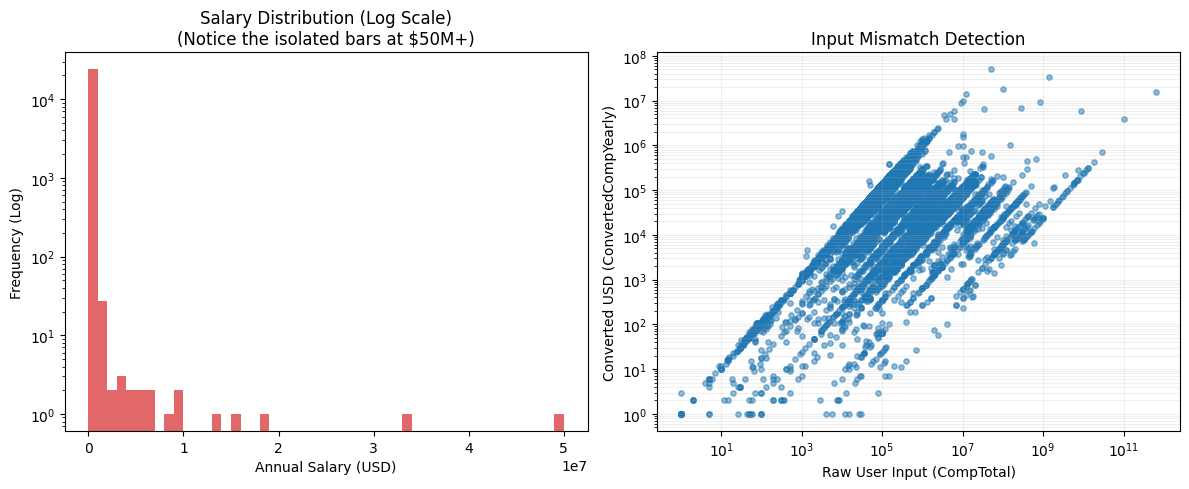

In [36]:
import seaborn as sns

# A. Missing Values Check
missing_count = data['ConvertedCompYearly'].isna().sum()
total_rows = len(data)
print(f"Target Variable Analysis:")
print(f"Total Rows: {total_rows}")
print(f"Missing Salary: {missing_count} ({missing_count/total_rows:.1%})")
print("Action: These rows must be dropped for regression training.\n")

# B. Outlier Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Log Scale Histogram
plt.subplot(1, 2, 1)
plt.hist(data['ConvertedCompYearly'].dropna(), bins=50, color='#d62728', alpha=0.7)
plt.yscale('log')
plt.title("Salary Distribution (Log Scale)\n(Notice the isolated bars at $50M+)")
plt.xlabel("Annual Salary (USD)")
plt.ylabel("Frequency (Log)")

# Plot 2: Raw Input vs Converted
plt.subplot(1, 2, 2)
subset = data.dropna(subset=['CompTotal', 'ConvertedCompYearly'])
plt.scatter(subset['CompTotal'], subset['ConvertedCompYearly'], alpha=0.5, s=15, c='#1f77b4')
plt.xscale('log'); plt.yscale('log')
plt.title("Input Mismatch Detection")
plt.xlabel("Raw User Input (CompTotal)")
plt.ylabel("Converted USD (ConvertedCompYearly)")
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

### 3. Inverted Ranking Logic
**Issue:** Ranking columns use `1` for "Best" and `14` for "Worst".
The heatmap below confirms that '1' is the most frequent choice for popular features, meaning this scale is inverted for regression analysis (where higher usually means 'more').

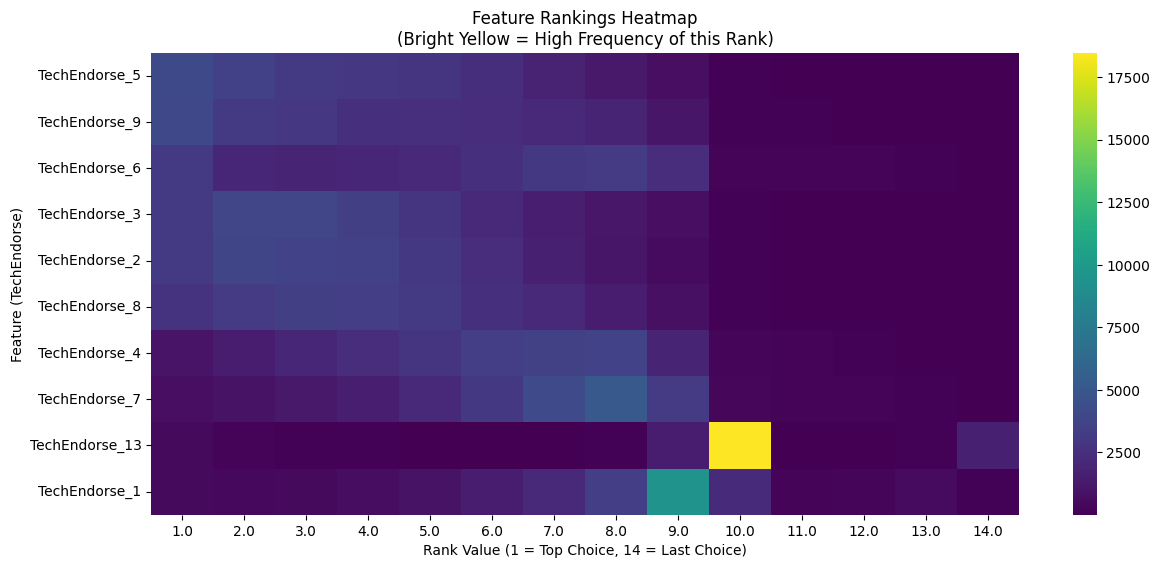

Insight: The bright vertical band at '1' confirms that 1 is the 'Best' value.
Action: Reverse coding is required (e.g., Score = 15 - Rank).


In [37]:
# Select ranking columns
rank_cols = [c for c in data.columns if 'TechEndorse_' in c and 'TEXT' not in c and 'Intro' not in c]

# Create a frequency table: How many times was each Item ranked 1, 2, 3...?
rank_counts = data[rank_cols].apply(pd.Series.value_counts).fillna(0).T

# Sort by who got the most "#1" rankings to make the plot readable
rank_counts = rank_counts.sort_values(by=1.0, ascending=False)

plt.figure(figsize=(14, 6))
sns.heatmap(rank_counts, cmap="viridis", annot=False)
plt.title("Feature Rankings Heatmap\n(Bright Yellow = High Frequency of this Rank)")
plt.xlabel("Rank Value (1 = Top Choice, 14 = Last Choice)")
plt.ylabel("Feature (TechEndorse)")
plt.show()

print("Insight: The bright vertical band at '1' confirms that 1 is the 'Best' value.")
print("Action: Reverse coding is required (e.g., Score = 15 - Rank).")

## 4./5./6. Structural Complexity (Encoding Requirements)
Finally, we inspect columns that require specialized encoding strategies:
* **Point 4 (Multi-Select):** `LanguageHaveWorkedWith` (Needs splitting).
* **Point 5 (Ordinal):** `EdLevel` (Needs ordered mapping).
* **Point 6 (High Cardinality):** `Country` (Needs Top-N grouping).

In [38]:
import numpy as np
import pandas as pd

# --- Configuration ---
# Threshold for "High Cardinality" (e.g., Country has 100+, Currency has 30+)
CARDINALITY_THRESHOLD = 15 

# Known Ordinal Columns (Hard to detect automatically, so we list them)
KNOWN_ORDINAL_COLS = ['Age', 'EdLevel', 'OrgSize', 'SOVisitFreq', 'SOPartFreq', 'SOComm']

# Lists to store results
multi_select_cols = []
ordinal_cols = []
high_cardinality_cols = []
text_drop_cols = []

print("--- Starting Column Analysis ---")

# Iterate through all Object (String) columns
for col in data.select_dtypes(include='object').columns:
    
    # 1. Check for Open-Ended Text (ending in _TEXT or _Other) -> DROP
    if '_TEXT' in col or '_Other' in col:
        text_drop_cols.append(col)
        continue

    # 2. Check for Multi-Select (Contains semicolon ';')
    # We check if a significant number of rows contain ';', excluding NaN
    series = data[col].dropna().astype(str)
    if series.str.contains(';').any():
        multi_select_cols.append(col)
        continue

    # 3. Check for Ordinal (Match against known list)
    if col in KNOWN_ORDINAL_COLS:
        ordinal_cols.append(col)
        continue
        
    # 4. Check for High Cardinality (Many unique values)
    unique_count = data[col].nunique()
    if unique_count > CARDINALITY_THRESHOLD:
        high_cardinality_cols.append(col)

# --- Output the Results in the Requested Format ---

# Point 5: Multi-Select
print(f"\n# --- Point 5: Multi-Select Check ({len(multi_select_cols)} columns found) ---")
print(f"Columns: {multi_select_cols}")
print("Action: Split by ';' and apply Multi-Hot Encoding.")

# Point 6: Ordinal
print(f"\n# --- Point 6: Ordinal Check ({len(ordinal_cols)} columns found) ---")
print(f"Columns: {ordinal_cols}")
print("Action: Map manually to integers (preserve hierarchy).")

# Point 7: High Cardinality
print(f"\n# --- Point 7: High Cardinality Check ({len(high_cardinality_cols)} columns found) ---")
print(f"Columns: {high_cardinality_cols}")
print(f"Action: Keep Top {CARDINALITY_THRESHOLD} most frequent, map rest to 'Other', then One-Hot Encode.")

# Extra: Open Text (To Drop)
print(f"\n# --- Extra: Open-Ended Text to Drop ({len(text_drop_cols)} columns found) ---")
print(f"Columns: {text_drop_cols}")
print("Action: Drop these columns (unstructured noise).")

--- Starting Column Analysis ---

# --- Point 5: Multi-Select Check (73 columns found) ---
Columns: ['EmploymentAddl', 'LearnCode', 'AILearnHow', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith', 'LanguageAdmired', 'LanguagesHaveEntry', 'LanguagesWantEntry', 'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith', 'DatabaseAdmired', 'DatabaseHaveEntry', 'DatabaseWantEntry', 'PlatformHaveWorkedWith', 'PlatformWantToWorkWith', 'PlatformAdmired', 'PlatformWantEntry', 'WebframeHaveWorkedWith', 'WebframeWantToWorkWith', 'WebframeAdmired', 'WebframeHaveEntry', 'WebframeWantEntry', 'DevEnvsHaveWorkedWith', 'DevEnvsWantToWorkWith', 'DevEnvsAdmired', 'DevEnvHaveEntry', 'SOTagsHaveWorkedWith', 'SOTagsWantToWorkWith', 'SOTagsAdmired', 'OpSysPersonal use', 'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith', 'OfficeStackAsyncAdmired', 'OfficeStackHaveEntry', 'CommPlatformHaveWorkedWith', 'CommPlatformWantToWorkWith', 'CommPlatformAdmired', 'CommPlatformHaveEntr

## 5. Automated Data Profiling (Using Schema Types)
Instead of manually inspecting every column, we leverage the `survey_results_schema.csv` file. By mapping the `type` column from the schema to our data, we can automatically identify the columns that require specific processing steps.

**The Logic:**
1.  **Type `RO` (Rank Order):** Corresponds to **Inverted Ranking Logic** (Point 3).
2.  **Type `Matrix`:** Corresponds to **Multi-Select Columns** (Point 5).
3.  **Type `TE` (Text Entry):**
    * If column name relates to years/salary $\rightarrow$ **Dirty Numeric** (Point 4).
    * Otherwise $\rightarrow$ **Open-Ended Text** (Point 7 - Drop).
4.  **Type `MC` (Multiple Choice):**
    * If in our "Ordinal List" $\rightarrow$ **Ordinal Encoding** (Point 6).
    * If many unique values (>15) $\rightarrow$ **High Cardinality** (Point 7).

In [39]:
import pandas as pd
import numpy as np

# Helper: Map Data Column -> Schema Type (Handling Prefix Matches like 'LanguageHave...' -> 'Language')
schema_map = dict(zip(schema['qname'], schema['type']))
sorted_qnames = sorted(schema['qname'].astype(str).tolist(), key=len, reverse=True)

def get_schema_type(col_name):
    if col_name in schema_map: return schema_map[col_name]
    # Prefix match for Matrix questions (e.g. LanguageHaveWorkedWith starts with Language)
    for q in sorted_qnames:
        if col_name.startswith(q): return schema_map[q]
    return None

# --- 2. Define Keywords & Lists ---
# Numeric concepts that might be hidden in Text Entry (TE) fields
NUMERIC_KEYWORDS = ['Years', 'Comp', 'WorkExp', 'Salary', 'Total', 'Age']
# Known Ordinal Columns (Manual List)
ORDINAL_COLS_MANUAL = ['Age', 'EdLevel', 'OrgSize', 'SOVisitFreq', 'SOPartFreq']

# --- 3. Scan & Categorize ---
inverted_logic_cols = []
multi_select_cols = []
dirty_numeric_cols = []
ordinal_cols = []
high_cardinality_cols = []
drop_text_cols = []

print("Scanning columns using Schema Types...")

for col in data.columns:
    q_type = get_schema_type(col)
    
    # Skip Target & ID
    if col in ['ConvertedCompYearly', 'ResponseId']: continue

    # A. Check for Open Text to DROP (e.g. _TEXT, _Other)
    if '_TEXT' in col or '_Other' in col:
        drop_text_cols.append(col)
        continue

    # B. Inverted Logic (Rank Order)
    if q_type == 'RO':
        inverted_logic_cols.append(col)
        continue

    # C. Multi-Select (Matrix)
    if q_type == 'Matrix':
        multi_select_cols.append(col)
        continue

    # D. Dirty Numeric vs Open Text (Text Entry)
    if q_type == 'TE':
        # If it sounds numeric (e.g. YearsCode), it's Dirty Numeric
        if any(k in col for k in NUMERIC_KEYWORDS):
            dirty_numeric_cols.append(col)
        else:
            drop_text_cols.append(col) # Otherwise it's just noise
        continue

    # E. Ordinal vs High Cardinality (Multiple Choice)
    if q_type == 'MC' or col in ORDINAL_COLS_MANUAL:
        if col in ORDINAL_COLS_MANUAL:
            ordinal_cols.append(col)
        elif data[col].nunique() > 15: # Threshold for High Cardinality
            high_cardinality_cols.append(col)
        continue

# --- 4. Print Results for the Report ---

print(f"\nNumeric Columns ({len(dirty_numeric_cols)}):")
print(f" -> {dirty_numeric_cols}")

print(f"\n[Point 3] Inverted Logic Columns ({len(inverted_logic_cols)}):")
print(f" -> {inverted_logic_cols[:5]} ...")

print(f"\n[Point 4] Multi-Select Columns ({len(multi_select_cols)}):")
print(f" -> {multi_select_cols[:5]} ...")

print(f"\n[Point 5] Ordinal Columns ({len(ordinal_cols)}):")
print(f" -> {ordinal_cols}")

print(f"\n[Point 6] High Cardinality Columns ({len(high_cardinality_cols)}):")
print(f" -> {high_cardinality_cols}")

print(f"\n[Point 6] Open Text/Noise to Drop ({len(drop_text_cols)}):")
print(f" -> {drop_text_cols[:5]} ...")

Scanning columns using Schema Types...

Numeric Columns (7):
 -> ['WorkExp', 'YearsCode', 'CompTotal', 'AIAgentKnowWrite', 'AIAgentOrchWrite', 'AIAgentObsWrite', 'AIAgentExtWrite']

[Point 3] Inverted Logic Columns (45):
 -> ['TechEndorse_1', 'TechEndorse_2', 'TechEndorse_3', 'TechEndorse_4', 'TechEndorse_5'] ...

[Point 4] Multi-Select Columns (44):
 -> ['LanguageHaveWorkedWith', 'LanguageWantToWorkWith', 'LanguageAdmired', 'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith'] ...

[Point 5] Ordinal Columns (5):
 -> ['Age', 'EdLevel', 'OrgSize', 'SOVisitFreq', 'SOPartFreq']

[Point 6] High Cardinality Columns (15):
 -> ['EmploymentAddl', 'LearnCode', 'AILearnHow', 'DevType', 'Country', 'Currency', 'SO_Dev_Content', 'AIFrustration', 'AIAgent_Uses', 'AgentUsesGeneral', 'AIAgentKnowledge', 'AIAgentOrchestration', 'AIAgentObserveSecure', 'AIAgentExternal', 'AIHuman']

[Point 6] Open Text/Noise to Drop (26):
 -> ['TechEndorse_13_TEXT', 'TechOppose_15_TEXT', 'JobSatPoints_15_TEXT', 'ToolCount

In [40]:
check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, threshold=3.0, columns=('ConvertedCompYearly',)) -> dict:
    results = {}
    # Work on a copy with a fresh integer index for stable reporting
    tmp = data.copy().reset_index(drop=True)

    col = 'ConvertedCompYearly'
    if col not in tmp.columns:
        results[col] = []
        return results

    # Coerce to numeric, ignore missing values
    values = pd.to_numeric(tmp[col], errors='coerce')

    valid = values.dropna()
    if valid.empty:
        results[col] = []
        return results

    mean = valid.mean()
    std = valid.std()
    if std == 0 or np.isnan(std):
        results[col] = []
        return results

    z_scores = (values - mean) / std
    mask = values.notna() & (np.abs(z_scores) > threshold)
    outliers = mask[mask].index

    outlier_info = [
        {
            'index': int(idx),
            'z_score': float(z_scores.loc[idx]),
            'value': float(values.loc[idx])
        }
        for idx in outliers
    ]

    results[col] = outlier_info
    return results

start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2)

# Log how many outlier entries were reported (and how many unique rows)
outliers_reported_count = sum(len(v) for v in outliers_report.values())
outlier_indices = {item['index'] for v in outliers_report.values() for item in v}
outliers_removed_unique = len(outlier_indices)

total_rows = len(data)

print(f"Outlier entries reported: {outliers_reported_count}")
print(f"Unique row indices flagged as outliers: {outliers_removed_unique}")
print(f"Out of {total_rows} original rows")
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"
co_comment = """
Identifying outliers with a dirty hack that uses the z-score of each row within in column and reports all values 
with a z-score higher than 2.2 as an outlier, which is not a reasonable threshold but used here to avoid not 
finding any outliers for demonstration purposes.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
    # ...
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
ior_comment = """
After inspecting the report the decision has been made to remove all outliers that were identfied for demonstration purpose3
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{co_comment}""" .', 
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Removing all outliers for demonstration purposes.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    # ...
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

Outlier entries reported: 40
Unique row indices flagged as outliers: 40
Out of 23947 original rows
{'ConvertedCompYearly': [{'index': 1965, 'z_score': 2.5949551743692747, 'value': 1300000.0}, {'index': 2014, 'z_score': 2.4866730894262643, 'value': 1250000.0}, {'index': 2082, 'z_score': 2.378391004483254, 'value': 1200000.0}, {'index': 2379, 'z_score': 3.0280835141413163, 'value': 1500000.0}, {'index': 3312, 'z_score': 2.292083685858578, 'value': 1160147.0}, {'index': 3843, 'z_score': 4.00262227862841, 'value': 1950000.0}, {'index': 3900, 'z_score': 4.860216391377053, 'value': 2346000.0}, {'index': 5534, 'z_score': 3.0280835141413163, 'value': 1500000.0}, {'index': 5829, 'z_score': 19.270396255592882, 'value': 9000000.0}, {'index': 6881, 'z_score': 3.022790685829302, 'value': 1497556.0}, {'index': 6954, 'z_score': 2.5949551743692747, 'value': 1300000.0}, {'index': 8576, 'z_score': 9.971399340257804, 'value': 4706124.0}, {'index': 8954, 'z_score': 3.461211853913358, 'value': 1700000.0}, 

**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

Index(['MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl',
       'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'DevType',
       ...
       'AIAgentKnowledge', 'AIAgentKnowWrite', 'AIAgentOrchestration',
       'AIAgentOrchWrite', 'AIAgentObserveSecure', 'AIAgentObsWrite',
       'AIAgentExternal', 'AIAgentExtWrite', 'AIHuman', 'AIOpen'],
      dtype='object', length=119)
ResponseId: count=23947, mean=22529.892, std=14372.544, min=1.000, max=49123.000
WorkExp: count=23469, mean=13.698, std=10.131, min=1.000, max=100.000
YearsCode: count=23838, mean=17.706, std=11.062, min=1.000, max=100.000
TechEndorse_1: count=22752, mean=8.018, std=2.287, min=1.000, max=14.000
TechEndorse_2: count=22752, mean=4.025, std=2.239, min=1.000, max=14.000
TechEndorse_3: count=22752, mean=4.025, std=2.288, min=1.000, max=14.000
TechEndorse_4: count=22752, mean=5.778, std=2.380, min=1.000, max=14.000
TechEndorse_5: count=22752, mean=4.038, std=2.410, min=1.000, max=14.000
TechEndor

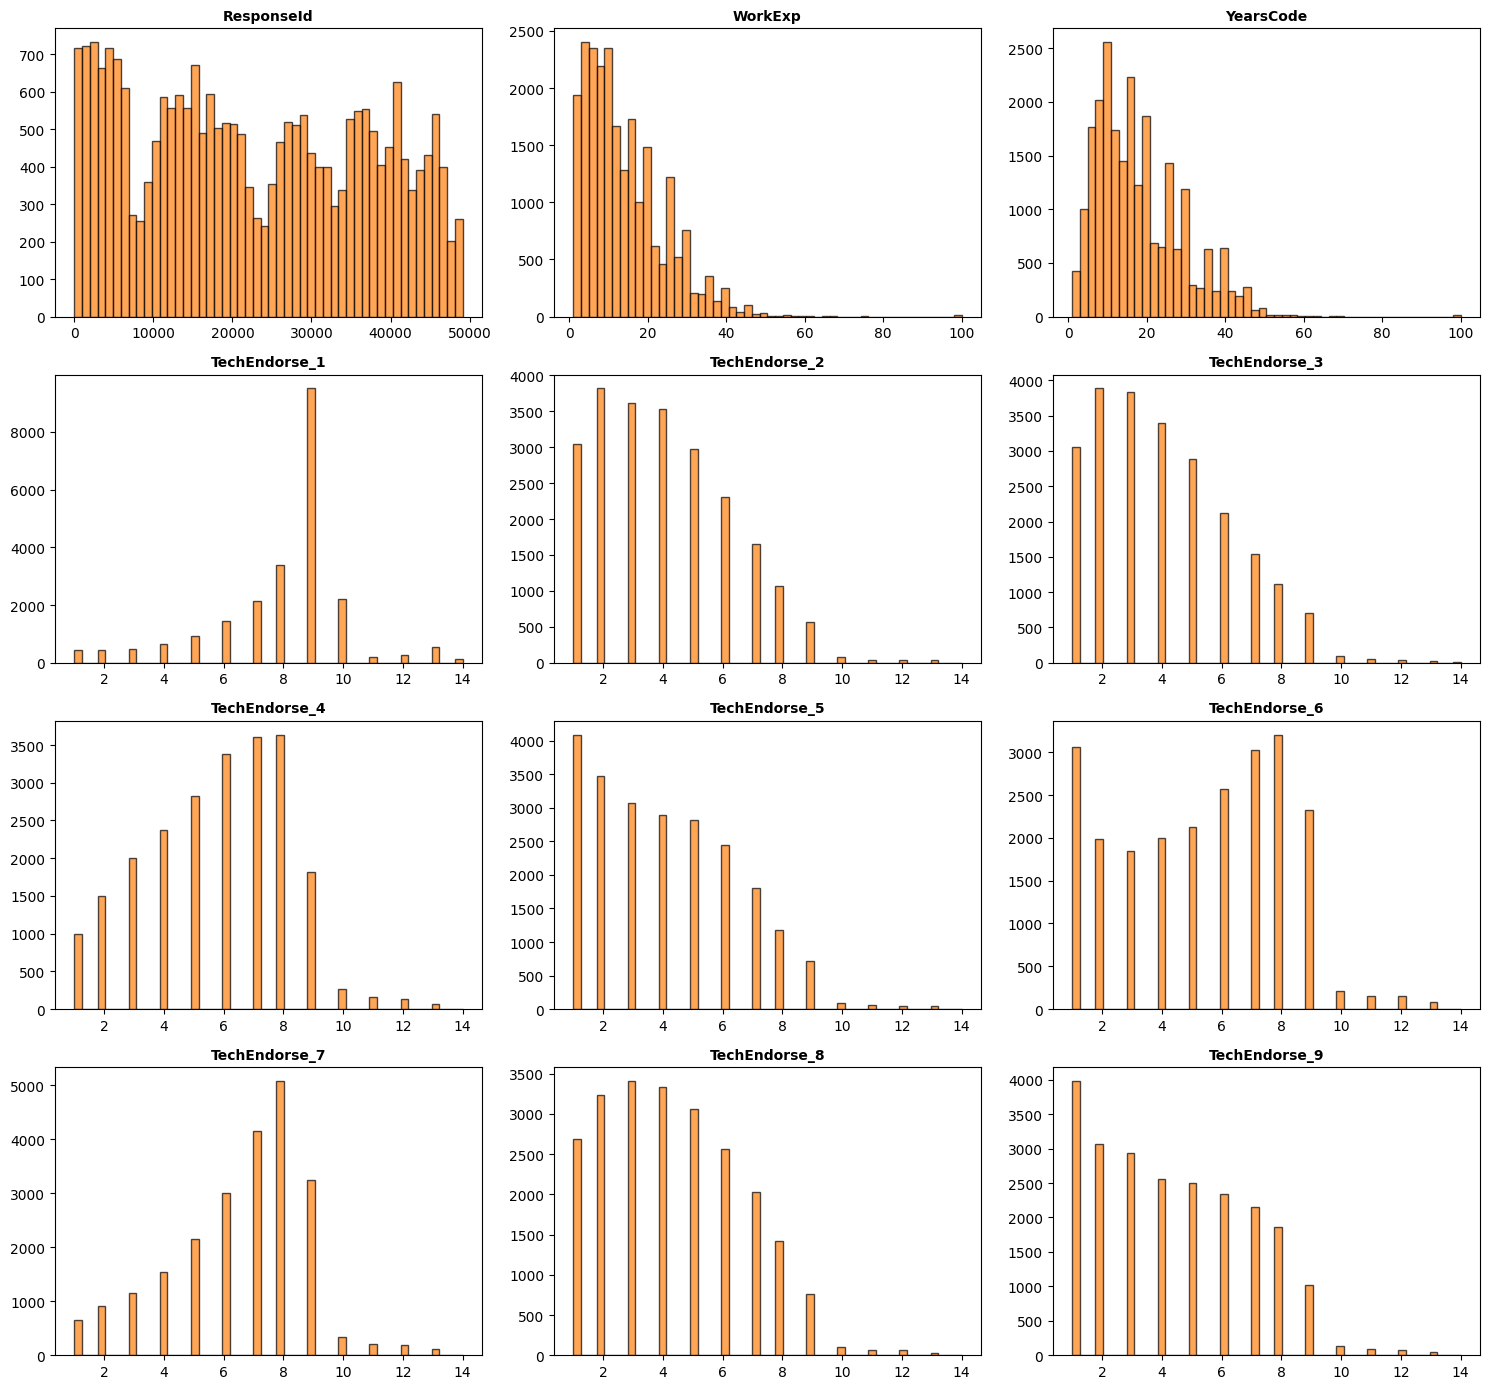

--- Showing plots 13 to 24 of 53 ---


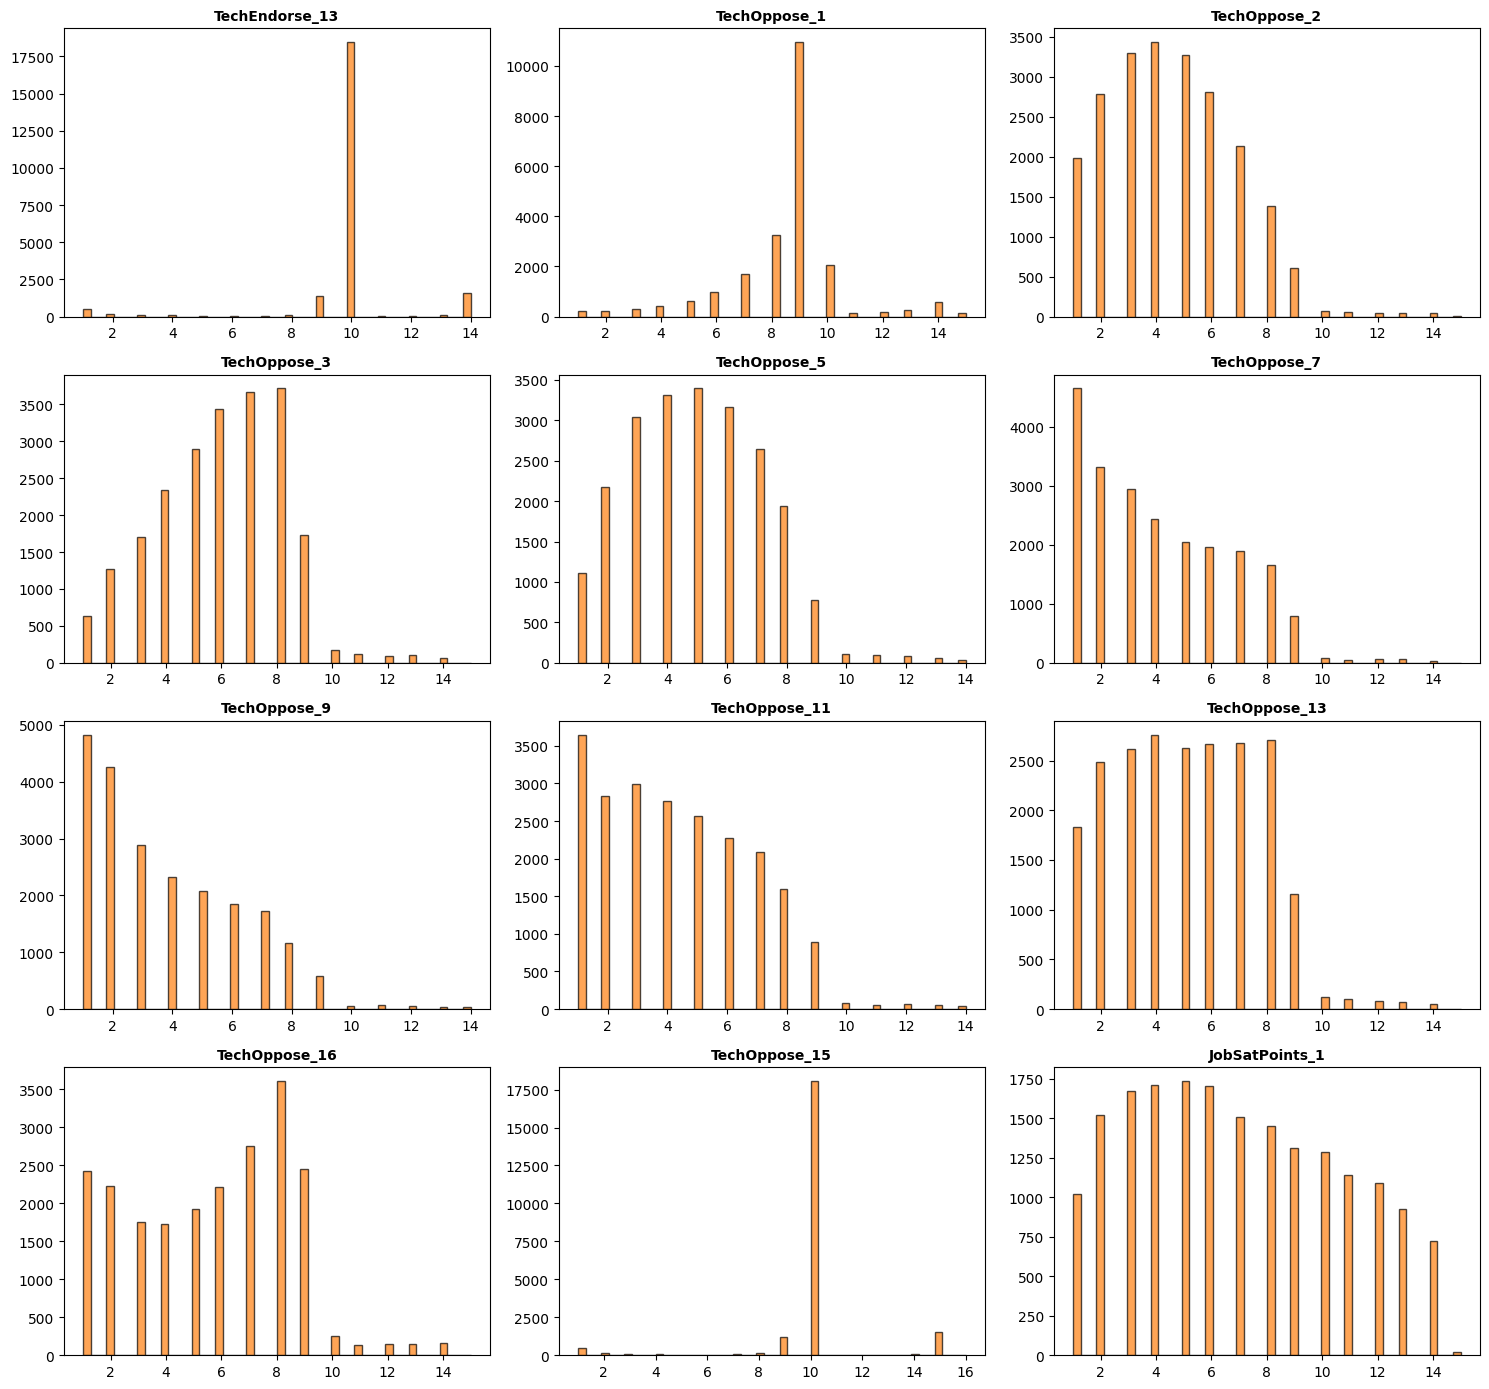

--- Showing plots 25 to 36 of 53 ---


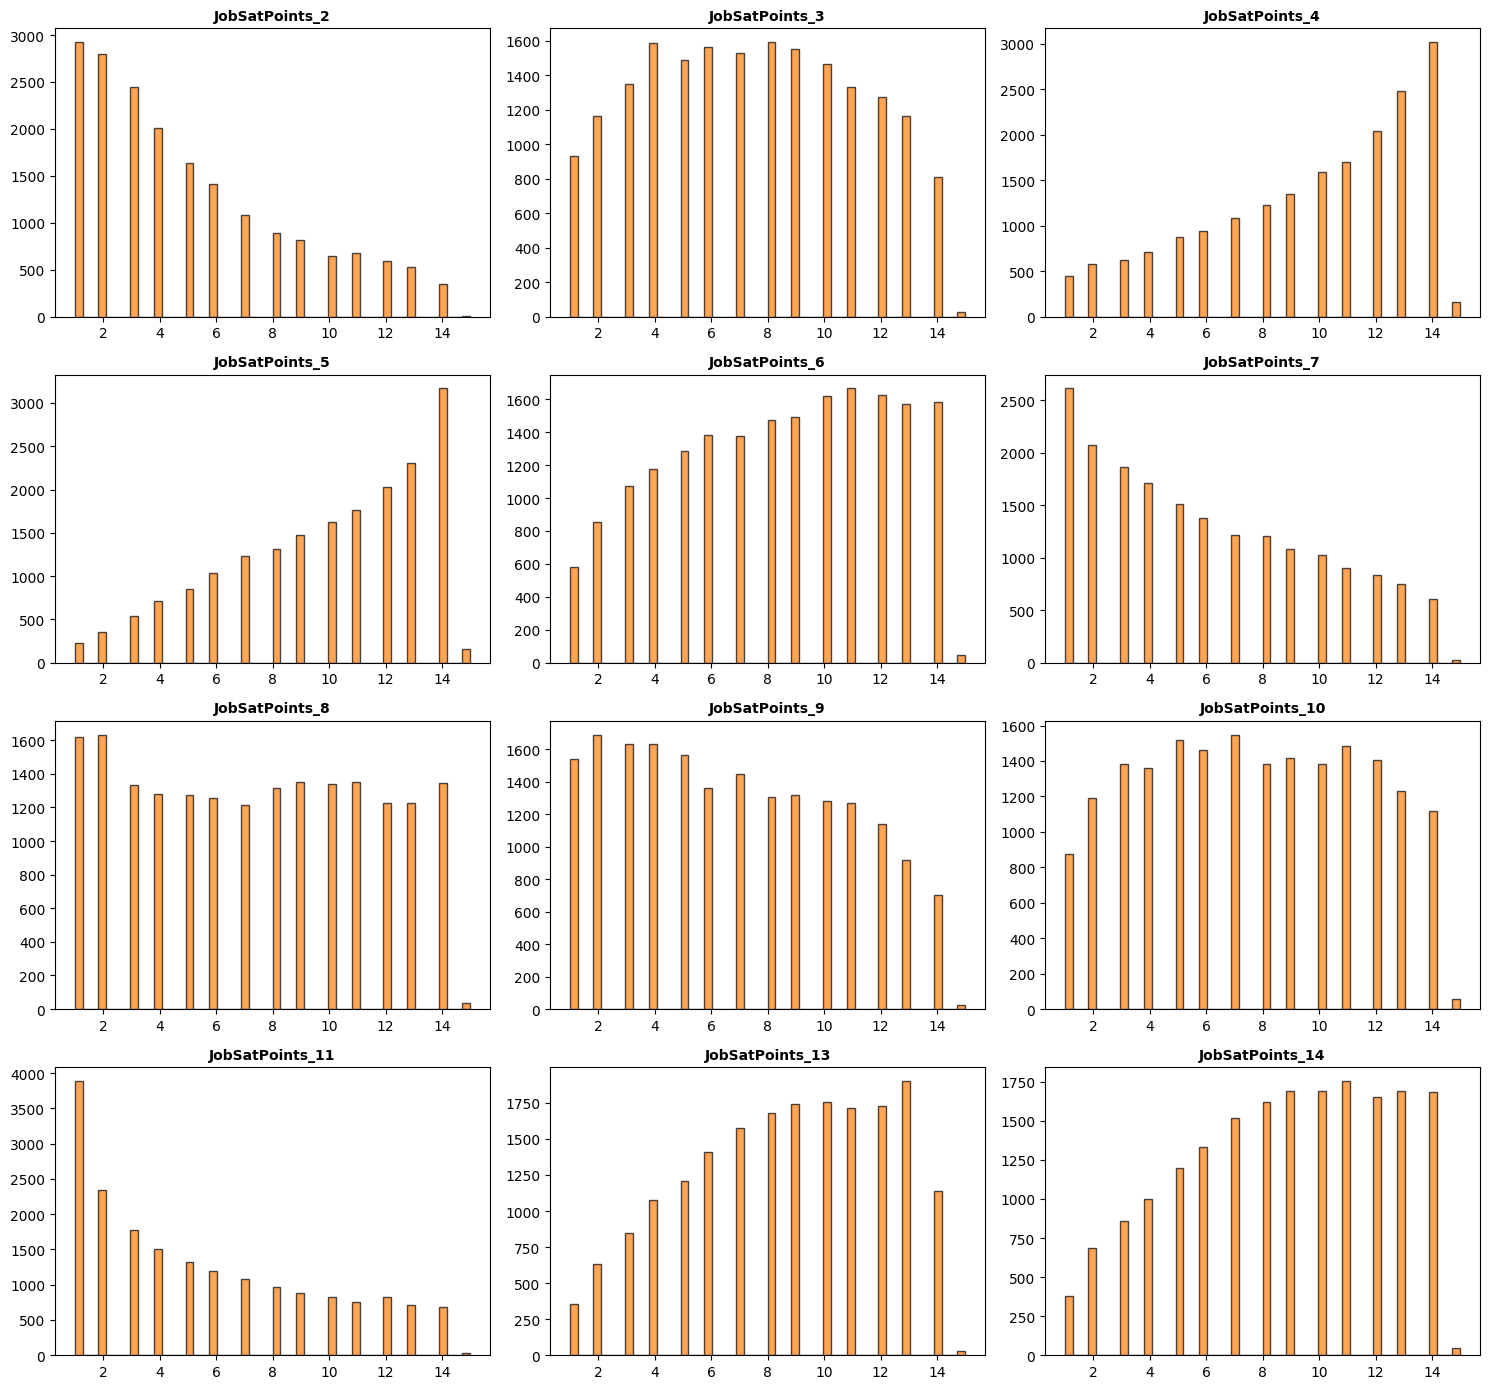

--- Showing plots 37 to 48 of 53 ---


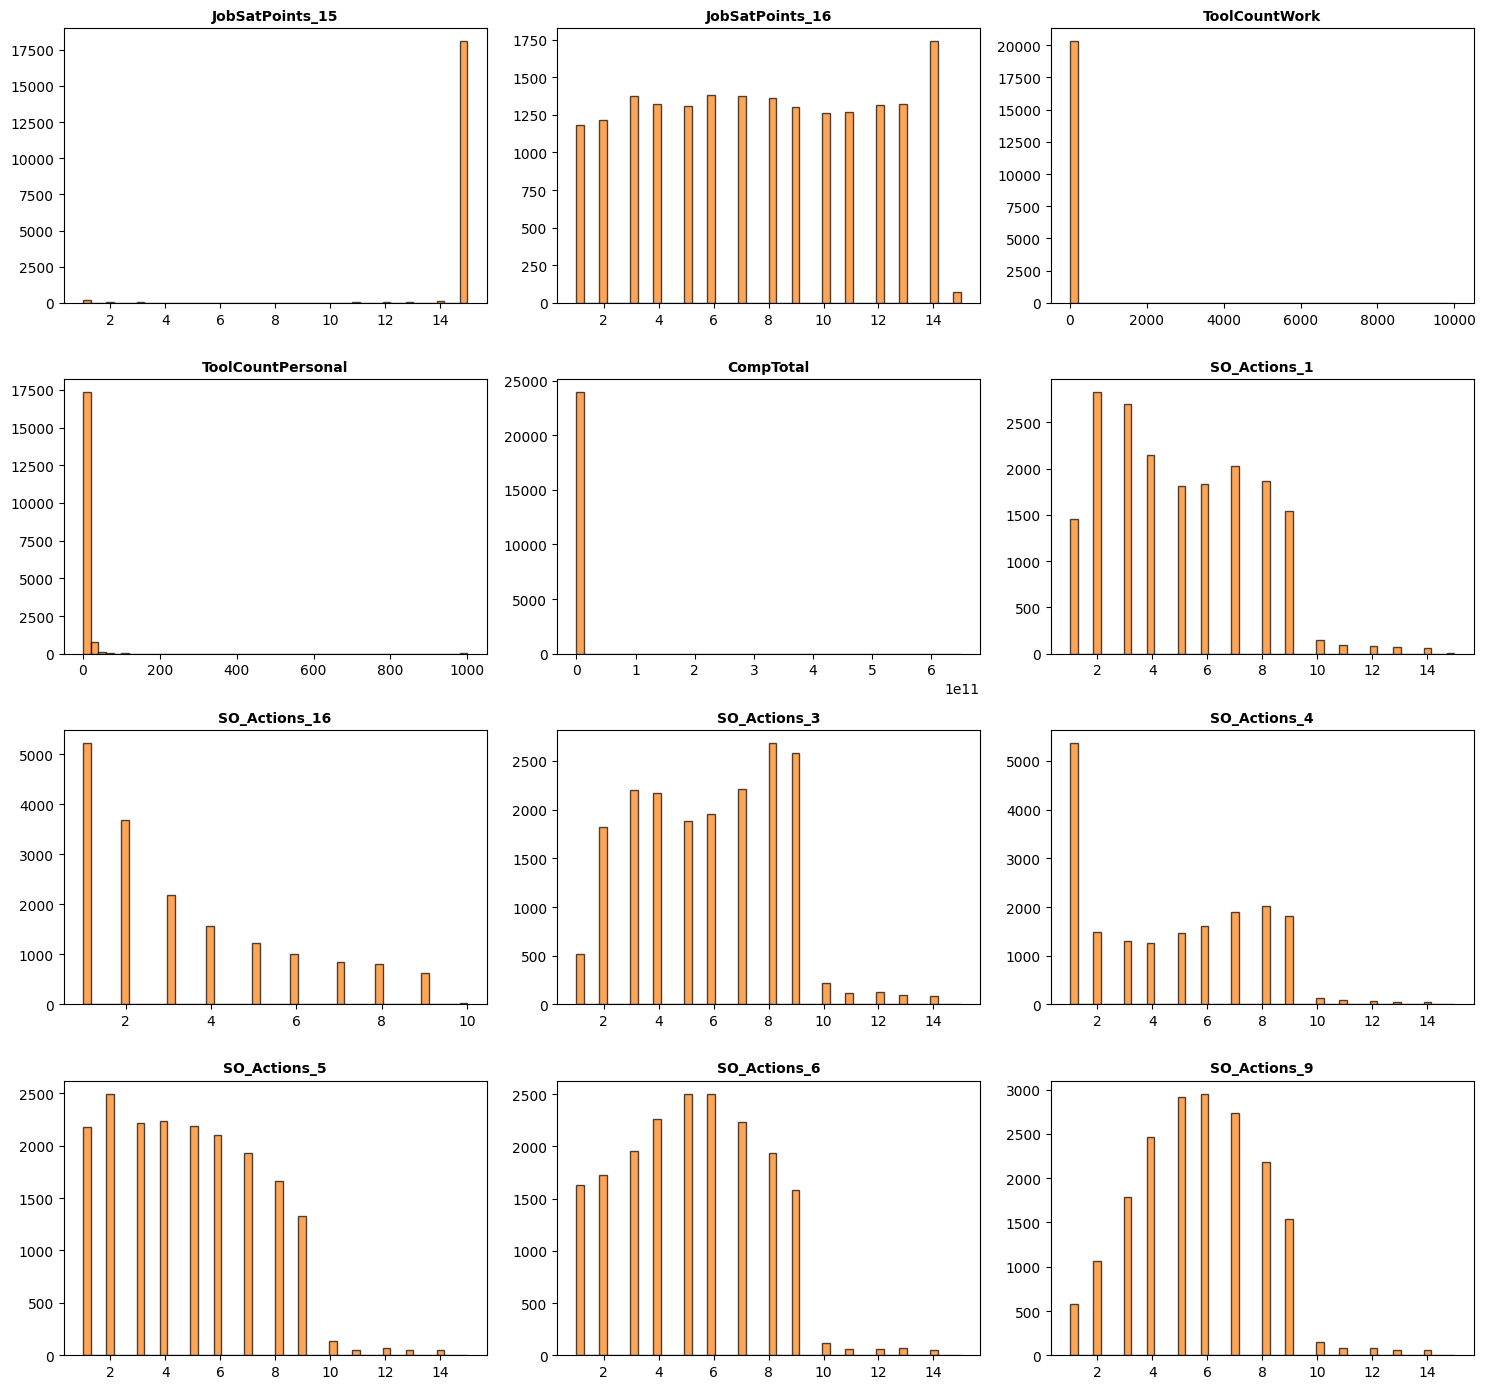

--- Showing plots 49 to 53 of 53 ---


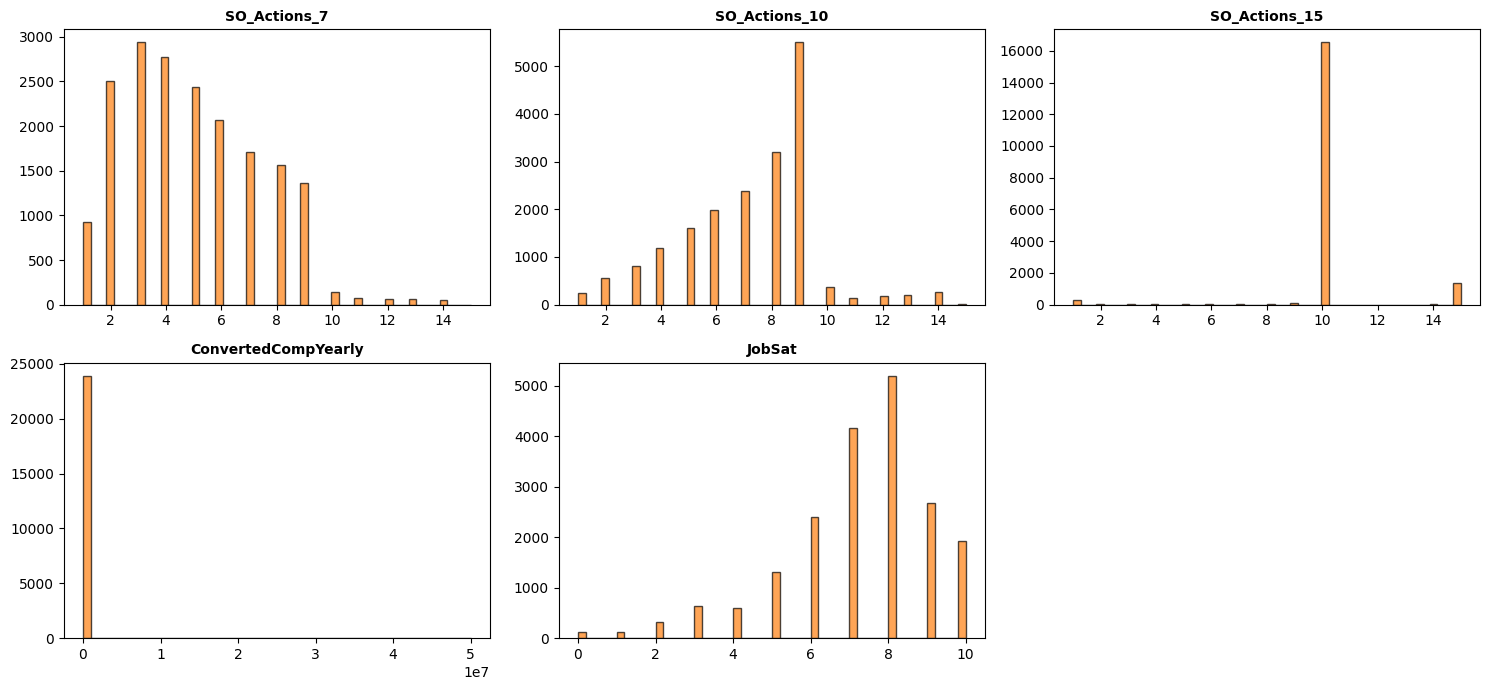

In [41]:
check_distribution_code_writer = student_a
# Check which columns are identified as objects
print(data.select_dtypes(include=['object']).columns)
# Distribution check for numeric columns (new cell at index 29)


def _to_native(x):
    # helper to convert numpy/pandas types to native python for JSON serialization
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (np.floating,)):
        return float(x)
    if isinstance(x, (np.ndarray, list, tuple)):
        return [_to_native(v) for v in x]
    if pd.isna(x):
        return None
    return x

def check_distribution(df: pd.DataFrame,
                       columns: typing.Optional[typing.Iterable[str]] = None,
                       bins: int = 50,
                       show_plot: bool = False) -> dict:
    """
    Compute distributions and summary statistics for numeric columns.

    - Ignores non-numeric columns.
    - If `columns` is provided, only those numeric columns (intersection) are processed.
    - Returns a dict: { column_name: { stats..., histogram: {counts, bins} } }

    If show_plot=True, a histogram is shown for each processed column (matplotlib).
    """
    numeric_cols = list(df.select_dtypes(include=[np.number]).columns)
    if columns is not None:
        # keep only numeric and requested columns
        numeric_cols = [c for c in numeric_cols if c in set(columns)]

    results: dict = {}
    for col in numeric_cols:
        # 1. Load the column
        s = df[col]
        
        # 2. Filter out NaNs AND Infinite values
        # np.isfinite(s) returns True only for regular numbers (excludes NaN, inf, -inf)
        series = s[np.isfinite(s)].astype(float)
        
        if series.empty:
            results[col] = {"note": "no valid numeric data (all empty or inf)"}
            continue

        q1 = series.quantile(0.25)
        q2 = series.quantile(0.5)
        q3 = series.quantile(0.75)
        hist_counts, hist_bins = np.histogram(series, bins=bins)

        stats = {
            "count": int(series.count()),
            "missing": int(df[col].isna().sum()),
            "unique": int(series.nunique()),
            "mean": float(series.mean()),
            "std": float(series.std()),
            "min": float(series.min()),
            "25%": float(q1),
            "50%": float(q2),
            "75%": float(q3),
            "max": float(series.max()),
            "skew": float(series.skew()),
            "kurtosis": float(series.kurtosis()),
        }

        hist = {
            "counts": [int(x) for x in hist_counts.tolist()],
            "bins": [float(x) for x in hist_bins.tolist()]
        }

        results[col] = {"stats": stats, "histogram": hist}

        if show_plot:
            plt.figure(figsize=(6, 3))
            plt.hist(series, bins=bins, color="C0", edgecolor="k", alpha=0.7)
            plt.title(f"Histogram: {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

    return results


# Run the distribution check on the loaded data (numeric columns only)
start_time_dist = now()
distribution_report = check_distribution(data, bins=50, show_plot=False)
end_time_dist = now()

# Print a compact summary for quick inspection
for col, info in list(distribution_report.items())[:10]:  # show up to first 10 columns
    if "stats" in info:
        s = info["stats"]
        print(f"{col}: count={s['count']}, mean={s['mean']:.3f}, std={s['std']:.3f}, min={s['min']:.3f}, max={s['max']:.3f}")
    else:
        print(f"{col}: {info.get('note', '')}")

# Document the activity in the provenance graph (serialized JSON in rdfs:comment)
dist_ass_uuid_executor = "f2e6b2a1-9a8c-4d7f-8123-0a1b2c3d4e5f"  # fixed id for executor association
dist_ass_uuid_writer = "e4d3c2b1-1234-4a5b-9cde-0f1e2d3c4b5a"    # fixed id for writer association

# Make a JSON-serializable copy
serializable_report = {}
for col, info in distribution_report.items():
    if isinstance(info, dict):
        serializable_report[col] = {}
        if "stats" in info:
            serializable_report[col]["stats"] = {k: _to_native(v) for k, v in info["stats"].items()}
        if "histogram" in info:
            serializable_report[col]["histogram"] = {
                "counts": _to_native(info["histogram"]["counts"]),
                "bins": _to_native(info["histogram"]["bins"])
            }
        if "note" in info:
            serializable_report[col]["note"] = info["note"]
    else:
        serializable_report[col] = _to_native(info)

# dist_comment = json.dumps(serializable_report, indent=2)

# check_distribution_activity = [
    # ':check_distribution rdf:type prov:Activity .',
    # ':check_distribution sc:isPartOf :data_understanding_phase .',
    # ':check_distribution rdfs:comment "Check distribution of numeric columns." .',
    # f':check_distribution prov:startedAtTime "{start_time_dist}"^^xsd:dateTime .',
    # f':check_distribution prov:endedAtTime "{end_time_dist}"^^xsd:dateTime .',
    # f':check_distribution prov:qualifiedAssociation :{dist_ass_uuid_writer} .',
    # f':{dist_ass_uuid_writer} prov:agent :{check_distribution_code_writer} .',
    # f':{dist_ass_uuid_writer} rdf:type prov:Association .',
    # f':{dist_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # ':check_distribution prov:used :data .',
    # ':distribution_report rdf:type prov:Entity .',
    # f':distribution_report rdfs:comment """{dist_comment}""" .',
    # ':distribution_report prov:wasGeneratedBy :check_distribution .',
# ]

# engine.insert(check_distribution_activity, prefixes=prefixes)
# print("Distribution check completed and documented.")

# Plot histograms from the distribution_report (first up to 12 numeric columns)
# ... (after your distribution report is created)

cols = list(distribution_report.keys())
batch_size = 12
total_plots = len(cols)

# Loop through the columns in chunks of 12
for i in range(0, total_plots, batch_size):
    batch_cols = cols[i : i + batch_size]
    
    # Setup the grid
    ncols = 3
    nrows = int(np.ceil(len(batch_cols) / ncols))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3.5))
    axes = np.array(axes).reshape(-1)
    
    print(f"--- Showing plots {i+1} to {min(i+batch_size, total_plots)} of {total_plots} ---")
    
    for ax_idx, col in enumerate(batch_cols):
        ax = axes[ax_idx]
        info = distribution_report[col]
        
        if "histogram" in info:
            hist = info["histogram"]
            counts = np.array(hist["counts"], dtype=float)
            bins = np.array(hist["bins"], dtype=float)
            widths = np.diff(bins)
            centers = bins[:-1] + widths / 2.0
            
            ax.bar(centers, counts, width=widths, color="C1", edgecolor="k", alpha=0.7) # Changed color to orange to signify 'new' view
            ax.set_title(col, fontsize=10, fontweight="bold")
        else:
            ax.text(0.5, 0.5, info.get("note", "No data"), ha="center")
            ax.set_title(col)
            
    # Hide unused axes in the last batch
    for j in range(len(batch_cols), len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()

## Data Preparation

In [42]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [43]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [110]:
# This cell is used only for the creation and afterwards copying uuids in order to be able to fullfill the provenance.
import uuid
print(str(uuid.uuid4()))

c6b8ac8d-6662-4b90-8913-1846063a3211


### 1. Missing Values in Target Variable

In [109]:
null_values_code_writer = student_b
def handleNulls(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    #df = pd.read_csv('data/stack-overflow-developer-survey-2025/survey_results_public.csv')
    rowsWithoutNull = df['ConvertedCompYearly'].notna().sum()

    print("Rows without null Value in ConvertedCompYearly: " + str(rowsWithoutNull))
    cleanedDataset = df.dropna(subset=['ConvertedCompYearly'])
    cleanedDataset.to_csv("Mav_TestData/output.csv", index=False)
    print("Finished deleting rows with NaN values")
    
    return cleanedDataset

start_time_td = now()
handleNulls(data, outliers_report)
end_time_td = now()


null_value_uuid_executor = "6ec9c276-2320-47bb-aa02-5e250434fd78"
null_values_executor = [
    f':handle_outliers prov:qualifiedAssociation :{null_value_uuid_executor} .',
    f':{null_value_uuid_executor} prov:agent :{executed_by} .',
    f':{null_value_uuid_executor} rdf:type prov:Association .',
    f':{null_value_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(null_values_executor, prefixes=prefixes)

print("Inserted executor")

null_value_uuid_writer = "29549238-43ae-470b-b427-b98b9796ac4d"
td_comment = """
Removed all NULL / NaN values in ConvertedCompYearly, as we need these values in order to calculated the average income
"""
null_values_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{null_value_uuid_writer} .',
    f':{null_value_uuid_writer} prov:agent :{null_values_code_writer} .',
    f':{null_value_uuid_writer} rdf:type prov:Association .',
    f':{null_value_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(null_values_activity, prefixes=prefixes)

print("Inserted writer")

Rows without null Value in ConvertedCompYearly: 23947
Finished deleting rows with NaN values
Inserted executor
Inserted writer


Text(0, 0.5, 'Frequency (Log)')

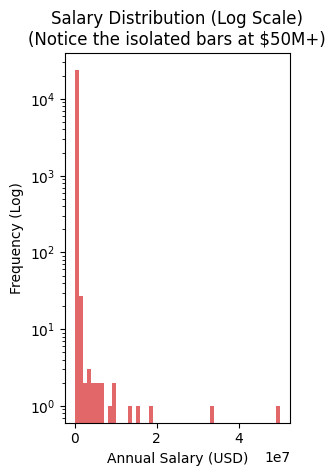

In [ ]:
#Plot from student a from above --> just taken in order to not always scrole up

plt.subplot(1, 2, 1)
plt.hist(data['ConvertedCompYearly'].dropna(), bins=50, color='#d62728', alpha=0.7)
plt.yscale('log')
plt.title("Salary Distribution (Log Scale)\n(Notice the isolated bars at $50M+)")
plt.xlabel("Annual Salary (USD)")
plt.ylabel("Frequency (Log)")

### 2. Removing Outliers

       ConvertedCompYearly
34267           50000000.0
28700           33552715.0
43143           18387548.0
35353           15430267.0
45971           13921760.0
48428           10000000.0
24900            9531653.0
10025            9000000.0
37352            6890299.0
30728            6371285.0
       ConvertedCompYearly
126               440856.0
40867             440856.0
26511             440000.0
13293             440000.0
20485             440000.0
45627             440000.0
22243             433975.0
12362             427300.0
39063             425000.0
14736             423454.0
Inserted executor
Inserted writer


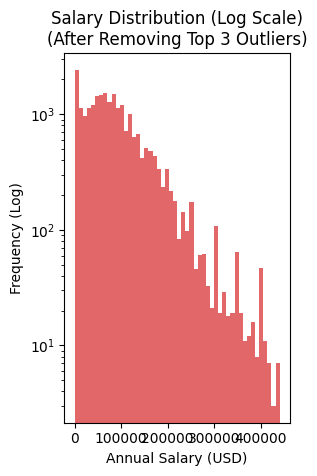

In [112]:
# Remove ConvertedCompYearly outliers 

### ATTENTION: I am create a copied dataset here in order to not mess with the original one while still testing the code ###

def removeOutliers(df: pd.DataFrame) -> pd.DataFrame:
    dfNew = df.copy()

    #Just for validation purposes once before and once after performing the deletion of rows by the 0,99 perceptile, to see the differences as well 
    topEarners = dfNew.sort_values(by='ConvertedCompYearly', ascending=False).head(10)
    print(topEarners[['ConvertedCompYearly']])

    p99 = dfNew['ConvertedCompYearly'].quantile(0.99)  
    dfNew = dfNew[dfNew['ConvertedCompYearly'] <= p99]

    topEarners = dfNew.sort_values(by='ConvertedCompYearly', ascending=False).head(10)
    print(topEarners[['ConvertedCompYearly']])

    #Taken from studen_a
    plt.subplot(1, 2, 1)
    plt.hist(dfNew['ConvertedCompYearly'].dropna(), bins=50, color='#d62728', alpha=0.7)
    plt.yscale('log')
    plt.title("Salary Distribution (Log Scale)\n(After Removing Top 3 Outliers)")
    plt.xlabel("Annual Salary (USD)")
    plt.ylabel("Frequency (Log)")

    return dfNew


start_time_td = now()
removeOutliers(data)
end_time_td = now()

outlier_remover_uuid_executor = "f41b9543-cf1e-403b-9bcd-00ddd0577055"
outlier_remover_executor = [
    f':handle_outliers prov:qualifiedAssociation :{outlier_remover_uuid_executor} .',
    f':{outlier_remover_uuid_executor} prov:agent :{executed_by} .',
    f':{outlier_remover_uuid_executor} rdf:type prov:Association .',
    f':{outlier_remover_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(outlier_remover_executor, prefixes=prefixes)

print("Inserted executor")

outlier_remover_uuid_writer = "c6b8ac8d-6662-4b90-8913-1846063a3211"
td_comment = """
Removed the outliers with the help of the 0,99 perceptile
"""

outlier_remover_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{outlier_remover_uuid_writer} .',
    f':{outlier_remover_uuid_writer} prov:agent :{outlier_remover_uuid_writer} .',
    f':{outlier_remover_uuid_writer} rdf:type prov:Association .',
    f':{outlier_remover_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(outlier_remover_activity, prefixes=prefixes)

print("Inserted writer")



In [150]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [151]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [152]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [153]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [154]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [155]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [156]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [157]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [158]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [159]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [160]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [161]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [162]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [163]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [164]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [165]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
